In [2]:
import numpy,sklearn,sklearn.datasets,utils
%matplotlib inline                                 # 1 This is a magic command to make matplotlib work in the notebook

UsageError: unrecognized arguments: # 1 This is a magic command to make matplotlib work in the notebook


# Principal Component Analysis

In this exercise, we will experiment with two different techniques to compute the PCA components of a dataset:

* **Singular Value Decomposition (SVD)**

* **Power Iteration**: A technique that iteratively optimizes the PCA objective.

We consider a random subset of the Labeled Faces in the Wild (LFW) dataset, readily accessible from sklearn, and we apply some basic preprocessing to discount strong variations of luminosity and contrast.

In [9]:
D = sklearn.datasets.fetch_lfw_people(resize=0.5)['images']                # Load the data set
D = D[numpy.random.mtrand.RandomState(1).permutation(len(D))[:2000]]*1.0   # Randomly select 2000 images
D = D - D.mean(axis=(1,2),keepdims=True)                                   # Subtract the mean
D = D / D.std(axis=(1,2),keepdims=True)                                    # Divide by the standard deviation
print(D.shape)                                                             # Print the shape of the data set

(2000, 62, 47)


Two functions are provided for your convenience and are available in `utils.py` that is included in the zip archive. The functions are the following:

* **`utils.scatterplot`** produces a scatter plot from a two-dimensional data set.

* **`utils.render`** takes an array of data points or objects of similar shape, and renders them in the IPython notebook.

Some demo code that makes use of these functions is given below.

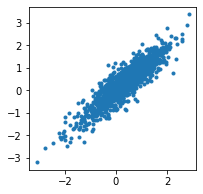

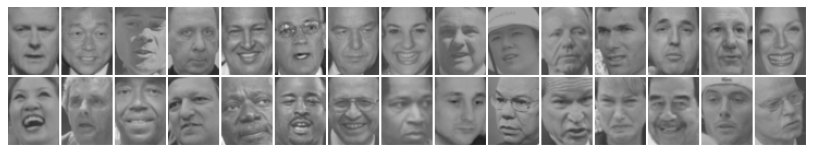

In [4]:
utils.scatterplot(D[:,32,20],D[:,32,21]) # Plot relation between adjacent pixels
utils.render(D[:30],15,2,vmax=5)         # Display first 10 examples in the data

## PCA with Singular Value Decomposition (15 P)

Principal components can be found computing a singular value decomposition. Specifically, we assume a matrix $\bar{X}$ whose columns contain the data points represented as vectors, and where the data points have been centered (i.e. we have substracted to each of them the mean of the dataset). The matrix $\bar{X}$ is of size $d \times N$ where $d$ is the number of input features and $N$ is the number of data points. This matrix, more specifically, the rescaled matrix $Z = \frac{1}{\sqrt{N}} \bar{X}$ is then decomposed using singular value decomposition:
$$
\textstyle U \Lambda V = Z
$$
The $k$ principal components can then be found in the first $k$ columns of the matrix $U$.

**Tasks:**

* **Compute the principal components of the data using the function `numpy.linalg.svd`.**
* **Measure the computational time required to find the principal components. Use the function `time.time()` for that purpose. Do *not* include in your estimate the computation overhead caused by loading the data, plotting and rendering.**
* **Plot the projection of the dataset on the first two principal components using the function `utils.scatterplot`.**
* **Visualize the 60 leading principal components using the function `utils.render`.**

Note that if the algorithm runs for more than 3 minutes, there may be some error in your implementation.

In [5]:
import time 

time_start = time.time()            # Start the timer

X = D.reshape([len(D),-1])          # Reshape the data set to a matrix
print(X.shape)                      # Print the shape of the data set

X = X.T                             # Transpose the data set
print(X.shape)                      # Print the shape of the data set

# The Data points are centered 
X = X - X.mean(axis=1,keepdims=True)       # Subtract the mean from the data set 
X1 = X / X.std(axis=1,keepdims=True)        # Divide by the standard deviation 
print(X.shape)                             # Print the shape of the data set
print(X1.shape)                            # Print the shape of the data set

# Calculate Z
Z = X /X.shape[1]**0.5                          
print(Z.shape)                             # Print the shape of the data set

U,L,V = numpy.linalg.svd(Z)                # Compute the SVD of Z 

time_end = time.time()                      # Stop the timer

print('Time elapsed: %f seconds' % (time_end - time_start)) # Print the time elapsed

(2000, 2914)
(2914, 2000)
(2914, 2000)
(2914, 2000)
(2914, 2000)
Time elapsed: 2.430144 seconds


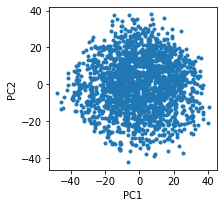

In [6]:
# Plot the first 2 principal components of the data set
utils.scatterplot(U[:,0].dot(X),U[:,1].dot(X),xlabel='PC1',ylabel='PC2') 

# As compare to previous plot, the data points are more spread out & the data points are more evenly distributed
# The axis of new plot are from (-40,40) to (-40,40), as compare to previous plot which is from (-2,2) to (-2,2)
# Along the Principal Component , the data points are more spread out, as compare to previous plot where the data points are more concentrated and this capture more signal. 


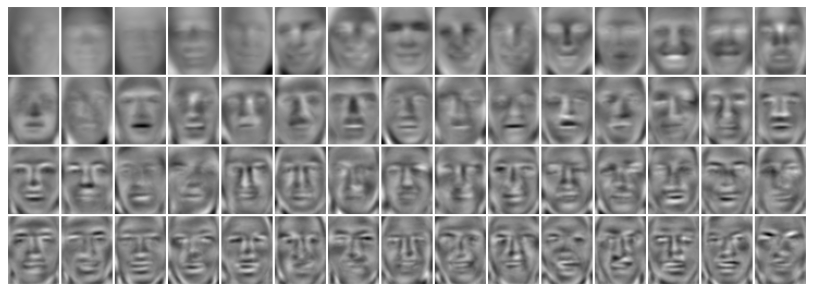

In [7]:
utils.render(U[:,:60].T,15,4)         # Display the first 60 principal components

# The first 60 principal components are able to capture the signal of the data set. 

When looking at the scatter plot, we observe that much more variance is expressed in the first two principal components than in individual dimensions as it was plotted before. When looking at the principal components themselves which we render as images, we can see that the first principal components correspond to low-frequency filters that select for coarse features, and the following principal components capture progressively higher-frequency information and are also becoming more noisy.

## PCA with Power Iteration (15 P)

The first PCA algorithm based on singular value decomposition is quite expensive to compute. Instead, the power iteration algorithm looks only for the first component and finds it using an iterative procedure. It starts with an initial weight vector $\boldsymbol{w} \in \mathbb{R}^d$, and repeatedly applies the update rule

$$
\boldsymbol{w} \leftarrow S \boldsymbol{w} \,\big/\, \|S \boldsymbol{w}\|.
$$

where $S$ is the covariance matrix defined as $S = \frac1N \bar{X}\bar{X}^\top$. Like for standard PCA, the objective that iterative PCA optimizes is $J(\boldsymbol{w}) = \boldsymbol{w}^\top S \boldsymbol{w}$ subject to the unit norm constraint for $\boldsymbol{w}$. We can therefore keep track of the progress of the algorithm after each iteration.

**Tasks:**

* **Implement the power iteration algorithm. Use as a stopping criterion the value of $J(\boldsymbol{w})$ between two iterations increasing by less than 0.01.**
* **Print the value of the objective function $J(\boldsymbol{w})$ at each iteration.**
* **Measure the time taken to find the principal component.**
* **Visualize the the eigenvector $\boldsymbol{w}$ obtained after convergence using the function `utils.render`.**

Note that if the algorithm runs for more than 1 minute, there may be some error in your implementation.

In [8]:
import numpy as np

# Transform the data
N = np.shape(X)[1]
d = np.shape(X)[0]
Xbar = np.sqrt(N)*Z
w = np.random.randn(d,1)                # Generate a random vector
w = w/np.linalg.norm(w)                 # Normalize the vector
S = 1/N*np.dot(Xbar,Xbar.T)             # Compute the covariance matrix (dxd)
def objective(w):                       
    return np.dot(w.T,np.dot(S,w))      

def update_w(S, w):                        
    return np.dot(S, w) / np.linalg.norm(np.dot(S, w)) 


iteration = 1
J_tminus1 = np.inf
while iteration < w.shape[0]:
    w = update_w(S, w)                    # Update unit vector
    J = objective(w)                      # Compute the new objective function  

    if np.abs(J-J_tminus1) < .01:
        break

    J_tminus1 = J
    print('iteration %2d:   J(w) =%10.3f'%(iteration,J))
    iteration += 1

iteration  1:   J(w) =   190.405
iteration  2:   J(w) =   223.749
iteration  3:   J(w) =   232.520
iteration  4:   J(w) =   241.113
iteration  5:   J(w) =   249.714
iteration  6:   J(w) =   257.311
iteration  7:   J(w) =   263.248
iteration  8:   J(w) =   267.454
iteration  9:   J(w) =   270.231
iteration 10:   J(w) =   271.979
iteration 11:   J(w) =   273.047
iteration 12:   J(w) =   273.687
iteration 13:   J(w) =   274.067
iteration 14:   J(w) =   274.291
iteration 15:   J(w) =   274.423
iteration 16:   J(w) =   274.500
iteration 17:   J(w) =   274.545
iteration 18:   J(w) =   274.571
iteration 19:   J(w) =   274.586


We observe that the computation time has decreased significantly. The difference of performance becomes larger as the number of dimensions and data points increases. We can observe that the principal component is the same (sometimes up to a sign flip) as the one obtained by the SVD algorithm.